# Flower Recognition using Pre-trained model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import os
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Sample images

In [2]:
flowers_dir = './Crop_img/'
flower_labels = sorted(os.listdir(flowers_dir))
flower_labels

['Babi',
 'Calimerio',
 'Chrysanthemum',
 'Hydrangeas',
 'Lisianthus',
 'PingPong',
 'Rosy',
 'Tana']

## Data Preprocessing

* Iterate through all images
* Resize image into (299,299,3) since the model expects this input shape
* Convert image into numpy array
* Append features in X and labels in y

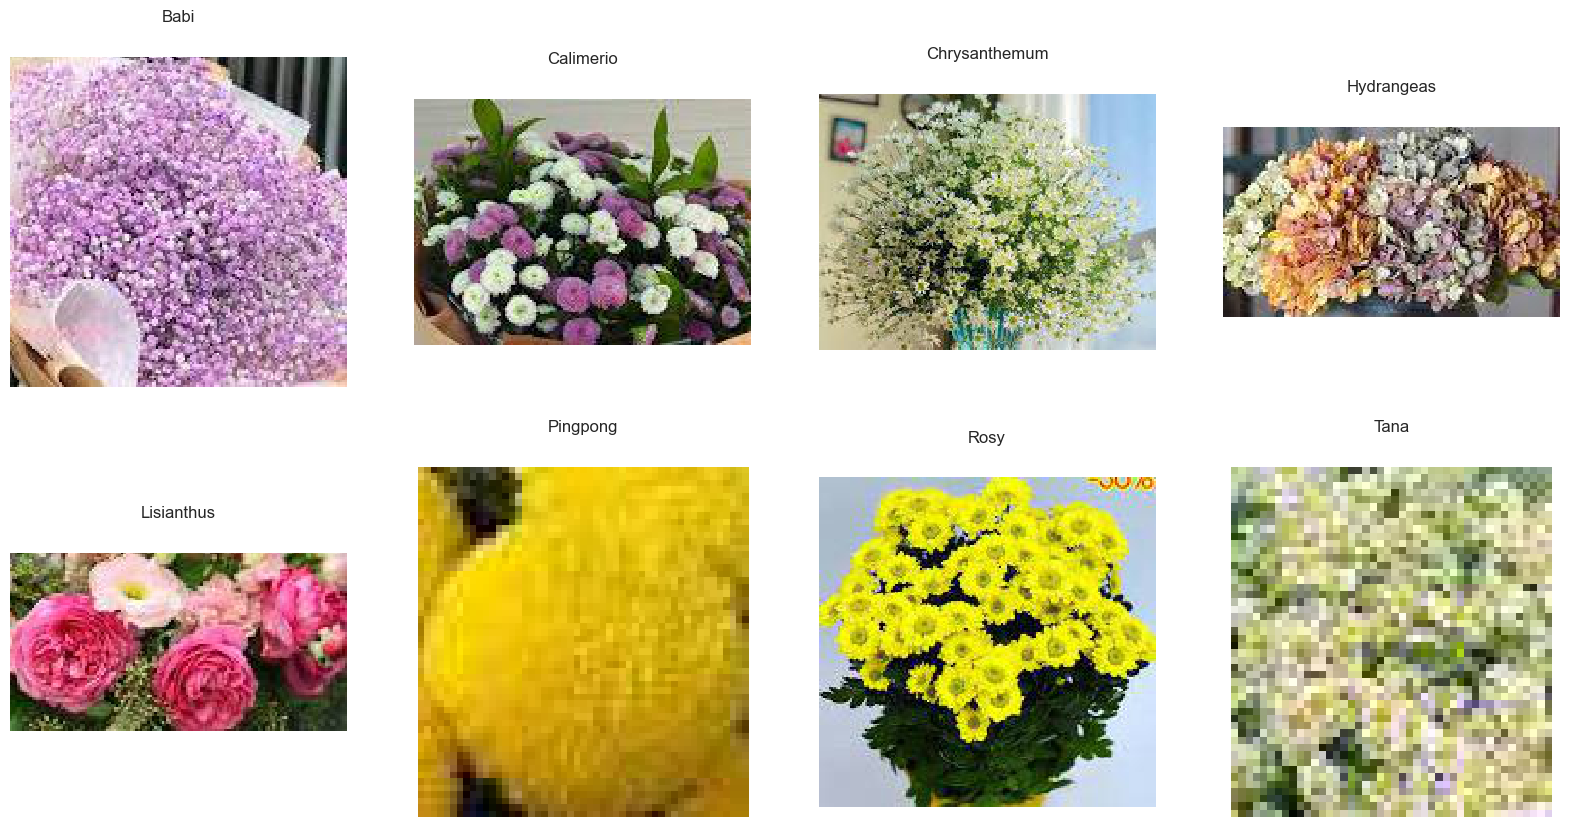

In [3]:
X = []
y = []

img_height = 299
img_width = 299

fig,ax = plt.subplots(2, 4, figsize=(20,10))
ax=ax.flatten()

flowers_dir_path_object = pathlib.Path(flowers_dir)

for label_number,flower in enumerate(flower_labels):
    # get all paths of images inside flower subdirectory
    flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    ax[label_number].set_title(flower.capitalize())
    ax[label_number].axis('off')
    flower_img = np.array(load_img(flower_images_paths[0].__str__()))
    ax[label_number].matshow(flower_img)
    # print(flower_images_paths[0].__str__())
    for image in flower_images_paths:
        # load and resize image
        resized_image = load_img(str(image),target_size=(img_height, img_width))
        # append features in X and labels in y
        X.append(np.array(resized_image))
        y.append(label_number)
        


In [4]:
import os

def scanData():
    data_count = pd.DataFrame(data={"flower": [], "count": []})
    meta_data_df = pd.DataFrame(data={"image_path": [], "flower_type": []})
    folder_path = flowers_dir

    subdirectories = next(os.walk(folder_path))[1]

    print(subdirectories)

    for i in subdirectories:
        sub = next(os.walk(folder_path+"/"+i))
        
        new_meta_data = pd.DataFrame(data={"image_path": [ (sub[0] + "/" + j) for j in sub[2]] , "flower_type": i})
        meta_data_df = pd.concat([meta_data_df, new_meta_data], ignore_index=True)
        
        new_data = pd.DataFrame(data={"flower": i, "count": len(sub[2])}, index=[0])      
        data_count = pd.concat([data_count, new_data], ignore_index=True)
        print(i, len(sub[2]), len([ sub[0] + j for j in sub[2]]))

    return data_count, meta_data_df

img_count, meta_data = scanData()
img_count

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'PingPong', 'Rosy', 'Tana']
Babi 889 889
Calimerio 1209 1209
Chrysanthemum 916 916
Hydrangeas 1098 1098
Lisianthus 3600 3600
PingPong 1957 1957
Rosy 302 302
Tana 601 601


,flower,count
0,Babi,889.0
1,Calimerio,1209.0
2,Chrysanthemum,916.0
3,Hydrangeas,1098.0
4,Lisianthus,3600.0
5,PingPong,1957.0
6,Rosy,302.0
7,Tana,601.0


<Axes: xlabel='flower', ylabel='count'>

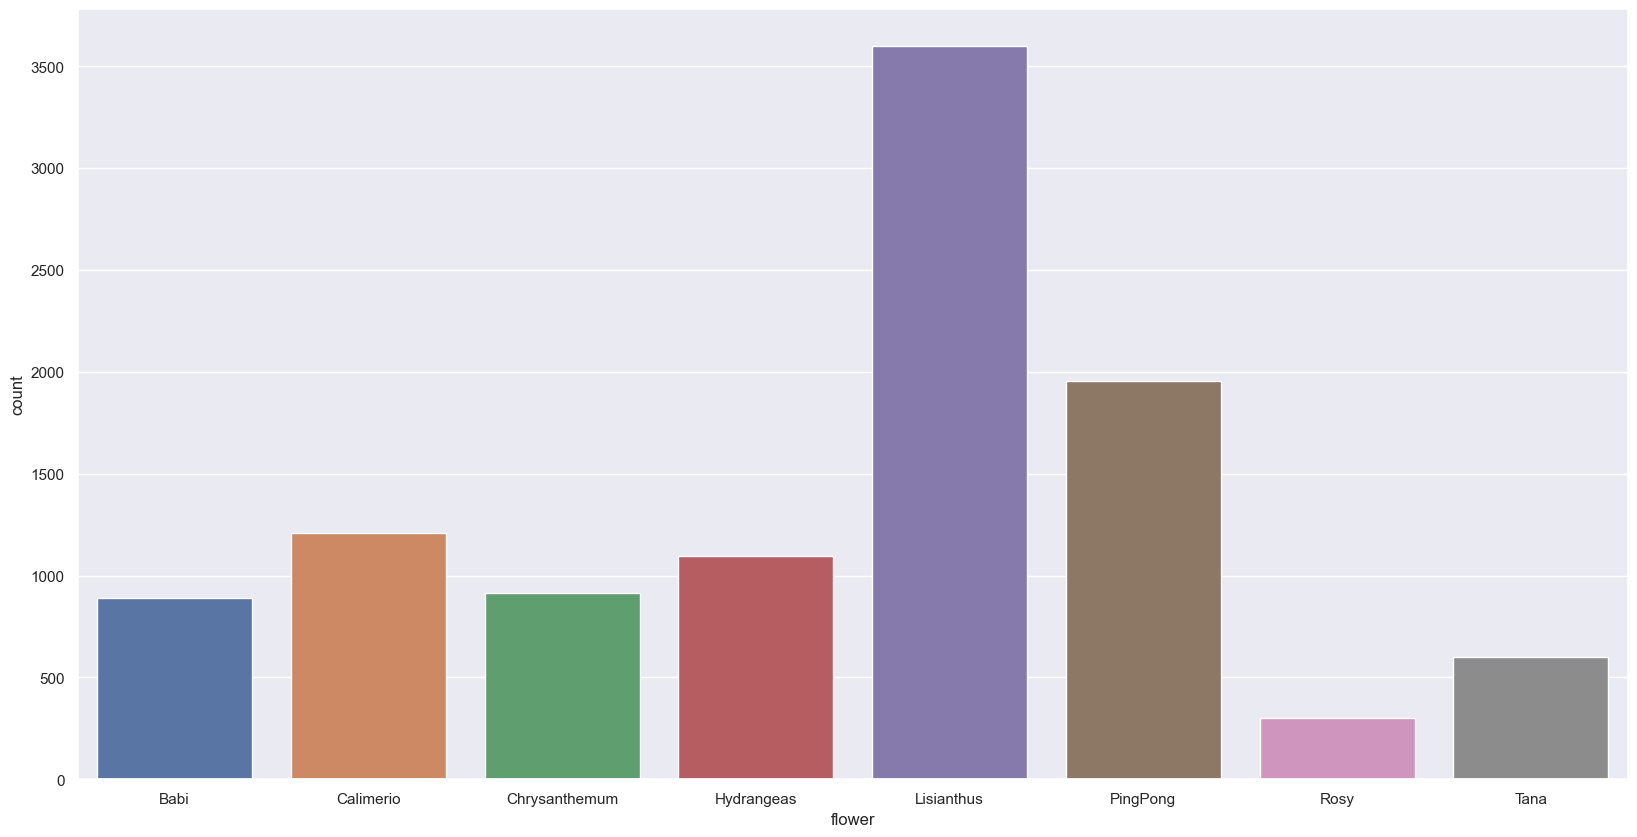

In [5]:
plt.figure(figsize=(20,10))
sns.barplot(data=img_count, x='flower', y='count')

In [6]:
X = np.array(X)
y = np.array(y)

print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (10572, 299, 299, 3)
y shape: (10572,)


## Model Building

* Train test split
* Fine-tuning pre-trained model
* Model evaluation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (7929, 299, 299, 3)
X test shape: (2643, 299, 299, 3)


In [8]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model, Sequential

In [9]:
def get_rpn_model():
    base_model = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(img_size, img_size, 3))
    feature_extractor = base_model.get_layer("block5_conv3")
    output = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="rpn_conv")(feature_extractor.output)
    anchor_count = 9
    rpn_cls_output = Conv2D(anchor_count, (1, 1), activation="sigmoid", name="rpn_cls")(output)
    rpn_reg_output = Conv2D(anchor_count * 4, (1, 1), activation="linear", name="rpn_reg")(output)
    rpn_model = Model(inputs=base_model.input, outputs=[rpn_reg_output, rpn_cls_output])
    return rpn_model, feature_extractor

In [10]:
def cls_loss(*args):
    """Calculating rpn class loss value.
    Rpn actual class value should be 0 or 1.
    Because of this we only take into account non -1 values.
    inputs:
        *args = could be (y_true, y_pred) or ((y_true, y_pred), )

    outputs:
        loss = BinaryCrossentropy value
    """
    y_true, y_pred = args if len(args) == 2 else args[0]
    indices = tf.where(tf.not_equal(y_true, tf.constant(-1.0, dtype=tf.float32)))
    target = tf.gather_nd(y_true, indices)
    output = tf.gather_nd(y_pred, indices)
    lf = tf.losses.BinaryCrossentropy()
    return lf(target, output)

def reg_loss(*args):
    """Calculating rpn / faster rcnn regression loss value.
    Reg value should be different than zero for actual values.
    Because of this we only take into account non zero values.
    inputs:
        *args = could be (y_true, y_pred) or ((y_true, y_pred), )

    outputs:
        loss = Huber it's almost the same with the smooth L1 loss
    """
    y_true, y_pred = args if len(args) == 2 else args[0]
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, 4))
    #
    loss_fn = tf.losses.Huber(reduction=tf.losses.Reduction.NONE)
    loss_for_all = loss_fn(y_true, y_pred)
    loss_for_all = tf.reduce_sum(loss_for_all, axis=-1)
    #
    pos_cond = tf.reduce_any(tf.not_equal(y_true, tf.constant(0.0)), axis=-1)
    pos_mask = tf.cast(pos_cond, dtype=tf.float32)
    #
    loc_loss = tf.reduce_sum(pos_mask * loss_for_all)
    total_pos_bboxes = tf.maximum(1.0, tf.reduce_sum(pos_mask))
    return loc_loss / total_pos_bboxes

In [12]:
img_size = 256

In [13]:
rpn_model, feature_extractor = get_rpn_model()
rpn_model.compile(optimizer=tf.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
                  loss=[reg_loss, cls_loss])

In [15]:
rpn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:


model = tf.keras.Sequential([
    
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",trainable=True),
    
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', 
#                            input_shape=(img_height, img_width)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     #VGG block 2
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#         #VGG block 3
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#         #VGG block 3
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
sgd_opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.8,
)
model.compile( optimizer=sgd_opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
model.summary()

In [ ]:
history = model.fit(X_train,y_train,batch_size=64,validation_split=0.2,epochs=30)

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
model.metrics_names

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.axhline(y = max(train_metric), color = 'r', linestyle = '-')
    plt.axhline(y = max(val_metric), color = 'b', linestyle = '-')

    plt.show()

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
predictions = model.predict(X_test)
max_predictions = [np.argmax(value) for value in predictions]
max_predictions[:5]
confusion_matrix_result = confusion_matrix(y_test,max_predictions)

labels = flower_labels
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Reds',fmt='.0f',xticklabels=labels,yticklabels=labels)
plt.title('Flower Recognition')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
classification_report_result = classification_report(y_test,max_predictions)
print(classification_report_result)

## Saving the model

In [ ]:
model.save('/kaggle/working/flower_recognition_pretrained.h5')